#### Objective

With this workflow I import an image with a map, isolate the map using morphological operations. The resulting image is the input to a colormap recognition and data extration workflow.

#### Preliminaries - import main libraries

In [1]:
import numpy as np

import matplotlib.pyplot as plt
from scipy import ndimage as ndi

from skimage import color, io
from skimage.morphology import disk, opening
from skimage.morphology import remove_small_objects

%matplotlib inline

#### Import test image

In [2]:
# import from url
url = 'http://oregonstate.edu/terra/wp-content/uploads/2011/12/US-Climate3.jpg'
img = np.asarray(io.imread(url))[:,:,:3] # removing alpha channel


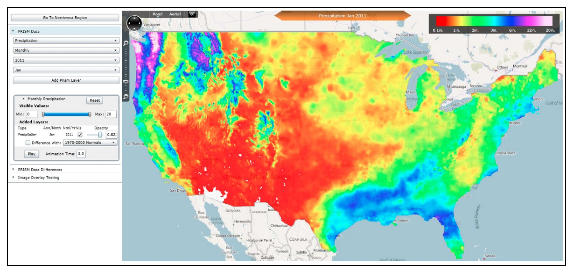

In [3]:
# plot it
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
plt.imshow(img)
ax.xaxis.set_ticks([])
ax.yaxis.set_ticks([])
plt.show()
#fig.savefig('input.png', dpi=400, bbox_inches='tight', pad_inches=0) 


#### Find the map

We want to eliminate both possibilities of ~black and ~nearly white border.

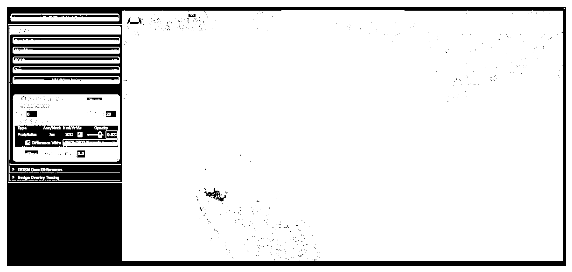

In [4]:
binary = np.logical_and(color.rgb2gray(img) > 0.03, color.rgb2gray(img) < 0.97)

# plot 
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
plt.imshow(binary, cmap='gray')
ax.xaxis.set_ticks([])
ax.yaxis.set_ticks([])
plt.show()

#fig.savefig('binary.png', dpi=400, bbox_inches='tight', pad_inches=0) 

#### Get largest element in the binary image and use it as a mask for the original image

First apply a light opening to separate possible small objects connected to the largest one (like tick marks).

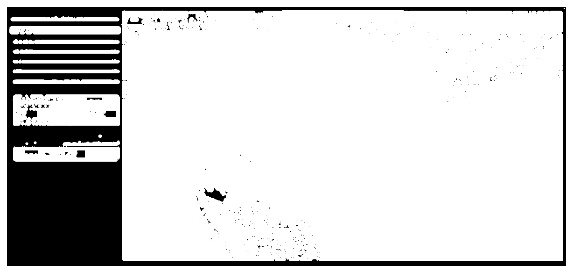

(554, 1198)

In [5]:
binary = opening(binary, disk(3))

# plot 
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
plt.imshow(binary, cmap='gray')
ax.xaxis.set_ticks([])
ax.yaxis.set_ticks([])
plt.show()
binary.shape
#fig.savefig('binary.png', dpi=400, bbox_inches='tight', pad_inches=0) 

Detect largest bright element in the binary image. Making the assumption it would be the map.
Eliminate everything else (text, colorbar, holes, etc.).

In [6]:
# Label all white objects (made up of ones)
label_objects, nb_labels = ndi.label(binary) # ndimage.label actually labels 0 (background) as 0 and then 
                                                    # labels every nonzero object as 1, 2, ... n. 
    
# Calculate every labeled object's size. 
# np.bincount ignores whether input is an image or another type of array.
# It just calculates the binary sizes, including for the 0 (background).
sizes = np.bincount(label_objects.ravel())   

sizes[0] = 0    # This sets the size of the background to 0 so that if it happened to be larger than 
                # the largest white object it would not matter

# Keep only largest object
binary_objects = remove_small_objects(binary, max(sizes)) 

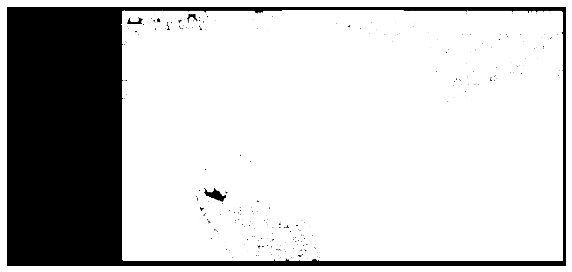

In [7]:
# plot 
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
plt.imshow(binary_objects, cmap='gray')
ax.xaxis.set_ticks([])
ax.yaxis.set_ticks([])
plt.show()
#fig.savefig('onlylargest.png', dpi=400, bbox_inches='tight', pad_inches=0) 

In [8]:
# Remove holes from it (black regions inside white object)
binary_holes = ndi.morphology.binary_fill_holes(binary_objects) 

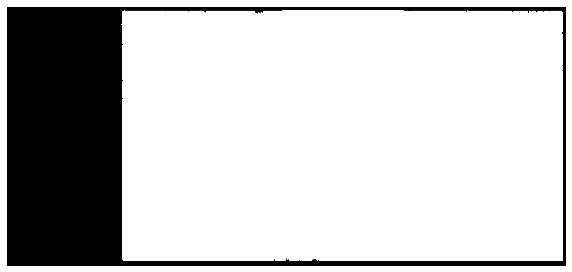

In [9]:
# plot 
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
plt.imshow(binary_holes, cmap='gray')
ax.xaxis.set_ticks([])
ax.yaxis.set_ticks([])
plt.show()

#fig.savefig('noholes.png', dpi=400, bbox_inches='tight', pad_inches=0) 

#### Mask and crop the original image


In [10]:
# Convert cleaned binary image to a 3D array mask to use in next cell

mask3 = np.zeros(img.shape)
mask3[:,:,0] = binary_holes
mask3[:,:,1] = binary_holes
mask3[:,:,2] = binary_holes

In [11]:
# Use the mask to get only the map in the original image
final = np.ma.masked_where(mask3 ==0, img)
final = final.filled(0)

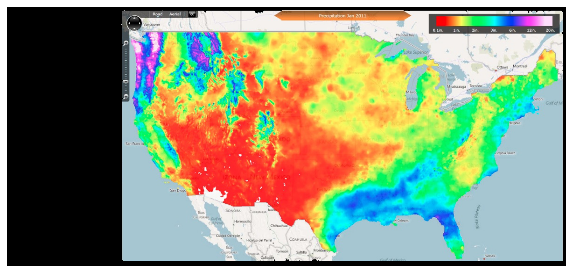

In [12]:
# plot 
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
plt.imshow(final)
ax.xaxis.set_ticks([])
ax.yaxis.set_ticks([])
plt.show()

#fig.savefig('map.png', dpi=400, bbox_inches='tight', pad_inches=0) 

#### Crop zero columns and zero rows

http://stackoverflow.com/a/14211727/1034648
or even better http://stackoverflow.com/a/31402351/1034648

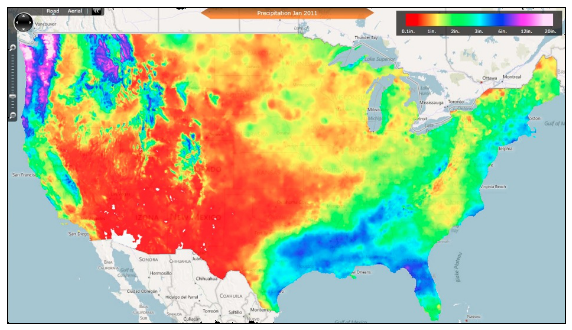

In [13]:
non_empty = np.where(final != 0)
final_crop = final[np.min(non_empty[0]) : np.max(non_empty[0]), 
                   np.min(non_empty[1]) : np.max(non_empty[1])]

#plot
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
plt.imshow(final_crop)
ax.xaxis.set_ticks([])
ax.yaxis.set_ticks([])
plt.show()
#fig.savefig('crop.png', dpi=400, bbox_inches='tight', pad_inches=0) 

#### Success!!